# Using Compartmental Models to Simulate and Visualise the Spread of Computer Viruses Across Networks

This notebook contains a project for simulating and visualising how viruses spread across networks using epidemiological compartmental models. This includes the code, experiments and documentation carried out as part of this project. See `README.md` for more details.

## Requirements and Setup

This project uses Python (version 3.10+) and Jupyter Notebook (version 7.1+). Additionally, it requires the following Python libraries:

- `numpy` (version 1.26+)
- `scipy` (version 1.12+)
- `matplotlib` (version 3.8+)
- `networkx` (version 3.2+)
- `ipympl` (version 0.9+)

More details can be found in `requirements.txt`. Please ensure these are installed before running the notebook.

## Usage

The notebook should already contain figures from running code and experiments. If not, select "Restart Kernel and Run All Cells..." from the "Run" drop-down menu.

This notebook uses the `widget` backend for `matplotlib`, enabling the user to interact with the figures with options to zoom, drag and pan the figure. Additionally, the simulation has UI elements to allow the user to "step" through the simulation and observe the spread of a virus across a network.

In [1]:
# Imports and basic setup here.

# Set the widget backend for matplotlib.
%matplotlib widget

# Main imports.
import networkx as nx
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

# Specific imports from certain modules.
from random import random, choice
from collections import Counter
from enum import StrEnum
from matplotlib.lines import Line2D
from matplotlib.widgets import Button

## Dataset

The dataset used in this project is the Enron email dataset, which can be found [here](https://networkrepository.com/email-enron-only.php) and is available locally in the `dataset.mtx` file. More information about the dataset can be found in the report. Details about the network along with a basic visualisation can be found below.

Number of nodes: 143
Number of edges: 623
Minimum degree: 1
Maximum degree: 42
Average degree: 8.713286713286713
Graph density: 0.061361174037230376


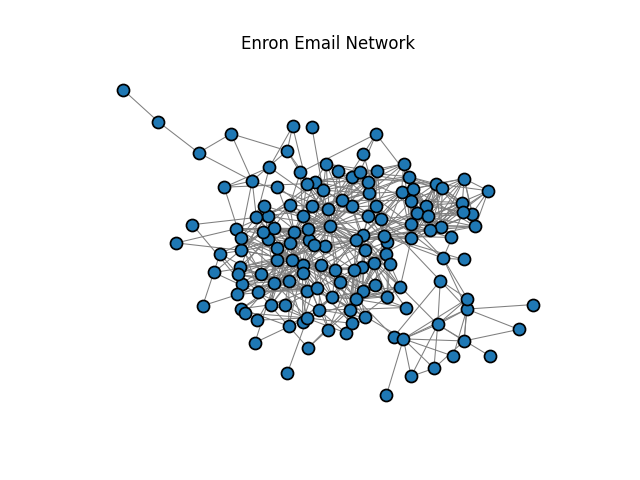

In [2]:
# Load the graph from the dataset.
dataset = sp.io.mmread("dataset.mtx")
graph = nx.Graph(dataset)

# Calculate some general data about the graph.
number_of_nodes = graph.number_of_nodes()
number_of_edges = graph.number_of_edges()

degrees = [d for n, d in graph.degree()]
min_degree = min(degrees)
max_degree = max(degrees)
avg_degree = sum(degrees) / len(degrees)

density = nx.density(graph)

# Output some data about the graph.
print(f"Number of nodes: {number_of_nodes}")
print(f"Number of edges: {number_of_edges}")
print(f"Minimum degree: {min_degree}")
print(f"Maximum degree: {max_degree}")
print(f"Average degree: {avg_degree}")
print(f"Graph density: {density}")

# Options for drawing the graph.
pos = nx.kamada_kawai_layout(graph)
graph_drawing_options = {
    "pos": pos,
    "node_size": 75,
    "edge_color": "tab:gray",
    "edgecolors": "black",
    "width": 0.75,
    "linewidths": 1.25,
}

# Draw the graph.
fig, axes = plt.subplots()
plt.title("Enron Email Network")
nx.draw(graph, **graph_drawing_options)
plt.show()

## Simulation

The following cell contains a class for running a simulation of the SIRV model on the network.

In [3]:
class NodeStates(StrEnum):
    """States of nodes in the simulation."""
    SUSCEPTIBLE = "Susceptible"
    INFECTIOUS = "Infectious"
    REMOVED = "Removed"
    VACCINATED = "Vaccinated"


# Colours for each different node state - these are used for visualisation.
node_state_colours = {
    NodeStates.SUSCEPTIBLE: "tab:blue",
    NodeStates.INFECTIOUS: "tab:red",
    NodeStates.REMOVED: "tab:gray",
    NodeStates.VACCINATED: "tab:green",
}


class SIRVSimulation:
    """SIRV model simulator class.
    
    This class is used to construct discrete event simulations of epidemiological
    compartmental models. This simulation is an incremental time simulation, where
    the state of the simulation is updated at each time step. The model used in
    this simulation is the SIRV model.

    Typical usage of this class is given below:

        simulation = SIRVSimulation()
        simulation.setup(graph)
        results = simulation.run()
    """
    def __init__(self, max_time=50):
        """Initialise the new ECMSimulation object.
        
        Args:
            max_time: an integer specifying the maximum number of time steps
                the simulation should run for.

        Returns: a new ECMSimulator object.
        """
        # Set the maximum run time of the simulation.
        self.max_time = max_time

        # Set simulation metadata.
        self.time = 0
        self.is_running = False
        self.termination_reason = None

        # Construct empty list to store simulation iterations.
        self.iterations = []

    def setup(self, graph, index_case=None, infection_probability=1.0, infectious_duration=0,
              vaccination_probability=0.05, vaccinate_at_start_only=True):
        """Setup the simulation with different parameters.
        
        Args:
            graph: a networkx.Graph object containing a graph.
            index_case: a node in graph specifying the index case.
            infection_probability: a floating point value specifying the infection
                probability of all nodes.
            infectious_duration: an integer specifying how many timesteps all node
                are infectious for. An infection_duration of 0 means the node will remain
                infectious forever.
            vaccination_probability: a floating point value specifying the vaccination
                probability.
            vaccinate_at_start_only: a boolean specifying if nodes should only be vaccinated
                at the start of the simulation.
        """
        # Store a copy of the original graph.
        self.graph = graph.copy()

        # Set state of all nodes to be susceptible.
        nx.set_node_attributes(self.graph, NodeStates.SUSCEPTIBLE, "state")

        # Check if an index case has been selected.
        if index_case == None:
            # Choose a random node to be the index case.
            index_case = choice(list(self.graph.nodes))

        # Set index case node to be infectious and set infection time.
        self.graph.nodes[index_case]["state"] = NodeStates.INFECTIOUS
        self.graph.nodes[index_case]["time infected"] = self.time

        # Set infection probabilities.
        nx.set_node_attributes(self.graph, infection_probability, "infection probability")

        # Set how long nodes are infectious for.
        nx.set_node_attributes(self.graph, infectious_duration, "infectious duration")

        # Set vaccination probabilities.
        nx.set_node_attributes(self.graph, vaccination_probability, "vaccination probability")

        # Set whether nodes should be vaccinated at the start of the simulation only or throughout
        # the simulation.
        self.vaccinate = not(vaccinate_at_start_only)

        # Get list of all susceptible nodes.
        susceptible_nodes = [n for n, d in self.graph.nodes(data=True) if d["state"] == NodeStates.SUSCEPTIBLE]

        # For all susceptible nodes...
        for node in susceptible_nodes:
            # Decide if the node should be vaccinated.
            if random() < self.graph.nodes[node]["vaccination probability"]:
                # Set new vaccinated state of the node and the time it was vaccinated at.
                self.graph.nodes[node]["state"] = NodeStates.VACCINATED
                self.graph.nodes[node]["time vaccinated"] = self.time

        # Set the simulation running flag.
        self.is_running = True

    def update(self):
        """Update the simulation."""
        # Check if nodes should be vaccinated.
        if self.vaccinate:
            # Get list of all susceptible nodes.
            susceptible_nodes = [n for n, d in self.graph.nodes(data=True) if d["state"] == NodeStates.SUSCEPTIBLE]

            # For all susceptible nodes...
            for node in susceptible_nodes:
                # Decide if the node should be vaccinated.
                if random() < self.graph.nodes[node]["vaccination probability"]:
                    # Set new vaccinated state of the node and the time it was vaccinated at.
                    self.graph.nodes[node]["state"] = NodeStates.VACCINATED
                    self.graph.nodes[node]["time vaccinated"] = self.time

        # Get list of all infectious nodes.
        infectious_nodes = [n for n, d in self.graph.nodes(data=True) if d["state"] == NodeStates.INFECTIOUS]

        # For all infectious nodes...
        for node in infectious_nodes:
            # Get all neighbouring nodes.
            neighbours = nx.neighbors(self.graph, node)

            # For all neighbouring nodes...
            for neighbour in neighbours:
                # Check if the node is susceptible to infection.
                if (self.graph.nodes[neighbour]["state"] == NodeStates.SUSCEPTIBLE
                    and random() < self.graph.nodes[neighbour]["infection probability"]):
                    # Set new infectious state of the node and the time it was infected at.
                    self.graph.nodes[neighbour]["state"] = NodeStates.INFECTIOUS
                    self.graph.nodes[neighbour]["time infected"] = self.time

            # Check if the node should transition to the removed state.
            if self.graph.nodes[node]["infectious duration"] == 0:
                # If the node has an infectious duration of 0, do nothing.
                pass
            else:
                # Calculate how long the node has been infectious for.
                node_infectious_duration = self.time - self.graph.nodes[node]["time infected"]

                # Check if the node has exceeded the maximum infection duration
                if node_infectious_duration >= self.graph.nodes[node]["infectious duration"]:
                    # Set the new removed state of the node and the time it was removed.
                    self.graph.nodes[node]["state"] = NodeStates.REMOVED
                    self.graph.nodes[node]["time removed"] = self.time

    def save_iteration(self):
        """Save an iteration of the simulation."""
        # Create empty colour map.
        colour_map = []

        # For all nodes in the current graph...
        for node in self.graph:
            # Get the state and relevant colour.
            state = self.graph.nodes[node]["state"]
            colour = node_state_colours[state]

            # Add the relevant node colour to the colour map.
            colour_map.append(colour)

        # Add counts for each state.
        node_states = nx.get_node_attributes(self.graph, "state")
        state_counts = Counter(node_states.values())

        # Construct iteration dictionary.
        iteration = {
            "time": self.time,
            "graph": self.graph.copy(),
            "colours": colour_map,
            "counts": state_counts,
        }

        # Add update to list of updates.
        self.iterations.append(iteration)

    def check_if_complete(self):
        """Check if the simulation is complete."""
        # If the current time is greater than or equal to the maximum
        # simulation runtime, stop the simulation.
        if self.time >= self.max_time:
            self.is_running = False
            self.termination_reason = "maximum time was reached"

        # Get states of all the nodes and counts for each state.
        state_counts = self.iterations[self.time]["counts"]

        # If all the nodes have been infected, removed or vaccinated,
        # i.e. there are no susceptible nodes left, stop the simulation.
        if state_counts[NodeStates.SUSCEPTIBLE] == 0:
            self.is_running = False
            self.termination_reason = "all nodes infected or vaccinated"

    def run(self):
        """Run the simulation.
        
        Returns:
            A dictionary containing the results of the simulation, including
            the termination reason, the final time and a list of graph updates.
        """
        # Save initial simulation iteration.
        self.save_iteration()

        # While the simulation is running...
        while self.is_running:
            # Increment the simulation time.
            self.time += 1

            # Update the state of the simulation.
            self.update()

            # Save updated simulation iteration.
            self.save_iteration()

            # Check if the simulation has completed.
            self.check_if_complete()

        # Construct results dictionary.
        results = {
            "reason": self.termination_reason,
            "time": self.time,
            "iterations": self.iterations,
        }

        # Return results.
        return results

The following cell demonstrates an example of setting up and running the simulation.

In [4]:
simulation = SIRVSimulation()
simulation.setup(graph, infection_probability=0.5, vaccinate_at_start_only=False, infectious_duration=4)
results = simulation.run()
print(f"Simulation terminated at time {results["time"]} with reason: {results["reason"]}")

Simulation terminated at time 33 with reason: all nodes infected or vaccinated


The following cell plots an area stack plot showing the distribution of different compartments in the simulation over time.

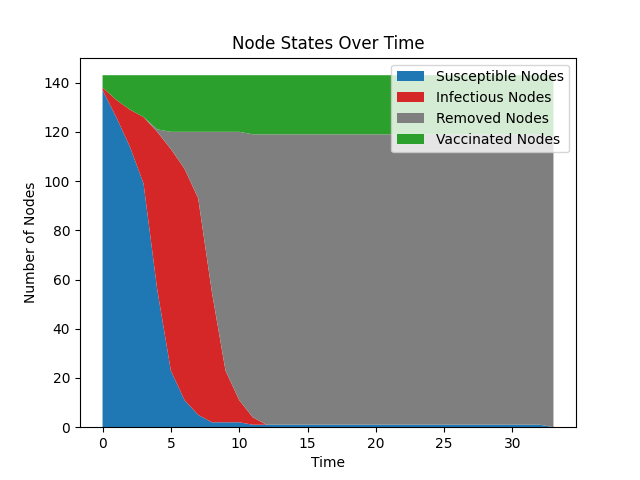

In [5]:
# Create empty list of times and dictionary of node counts.
times = []
node_counts = {k: [] for k in NodeStates}

# For all iterations in the simulation...
for iteration in results["iterations"]:
    # Get the time.
    times.append(iteration["time"])

    # For all possible states.
    for state in NodeStates:
        # Get the counts for each state.
        node_counts[state].append(iteration["counts"][state])

# Create new figure.
fig = plt.figure()

# Set title and labels for axis.
plt.title("Node States Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Nodes")

# Set X and Y data and prepare labels.
x = times
y = [node_counts[state] for state in NodeStates]
labels = [f"{state} Nodes" for state in NodeStates]

# Plot data using a stack plot.
plt.stackplot(x, y, labels=labels, colors=node_state_colours.values())

# Show the legend.
plt.legend()

# Show the plot.
plt.show()

The follwing cell contains a class which can be used to visualise and interact with the simulation. This includes options to view the simulation, switch to the previous or next iteration in the simulation, or reset back to the first iteration of the simulation.

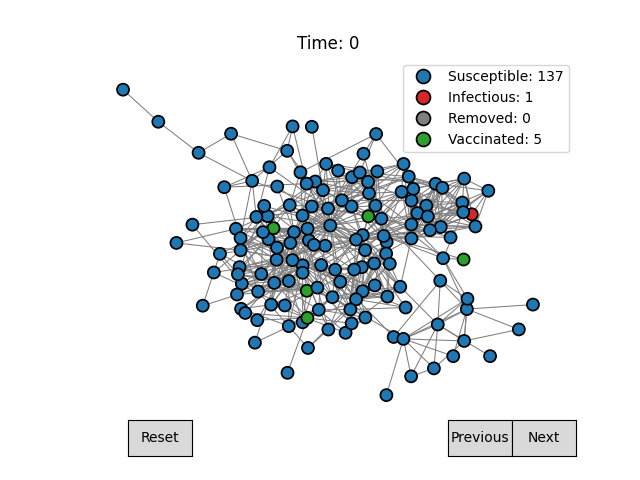

In [6]:
# Legend options.
legend_options = {
    "linestyle": "",
    "marker": "o",
    "markersize": 10,
    "markeredgewidth": 1.25,
    "markeredgecolor": "black",
}


class DrawInteractiveSimulation:
    """Draw interactive simulation class.
    
    This class is used for drawing different iterations of the simulation
    using interactive buttons.

    Typical usage of this class is as follows:

        # Run simulation and get results.
        fig, ax = plt.subplots()
        drawer = DrawInteractiveSimulation(fig, ax, iterations)
        next_button, previous_button = drawer.get_buttons()
        plt.show()
    """
    def __init__(self, fig, ax, iterations):
        """Initialise the new DrawInteractiveSimulation object.
        
        Args:
            fig: a matplotlib.fig object.
            ax: a matplotlib.ax object.
            iterations: a list of iterations to draw.
        """
        # Set figure, axes and iterations.
        self.fig = fig
        self.ax = ax
        self.iterations = iterations

        # Set current index (the current iteration to draw) and max index.
        self.current_index = 0
        self.max_index = len(self.iterations)

        # Setup the button locations.
        ax_previous = self.fig.add_axes([0.7, 0.05, 0.1, 0.075])
        ax_next = self.fig.add_axes([0.8, 0.05, 0.1, 0.075])

        ax_reset = self.fig.add_axes([0.2, 0.05, 0.1, 0.075])

        # Create next button.
        self.next_button = Button(ax_next, 'Next')
        self.next_button.on_clicked(self.next)
        
        # Create previous button.
        self.previous_button = Button(ax_previous, 'Previous')
        self.previous_button.on_clicked(self.previous)

        # Create reset button.
        self.reset_button = Button(ax_reset, "Reset")
        self.reset_button.on_clicked(self.reset)

        # Draw to the screen.
        self.draw()

    def get_buttons(self):
        """Get the buttons used in the interactive simulation drawer.
        
        This is done to prevent the buttons from becoming non-interactive due
        to being garbage collected. From the API reference: "To guarantee that
        the widget remains responsive and not garbage-collected, a reference
        to the object should be maintained by the user." For more details, see:
        https://matplotlib.org/stable/api/widgets_api.html
        
        Returns:
            A tuple of matplotlib.widget.Button objects.
        """
        # Return the buttons.
        return self.next_button, self.previous_button, self.reset_button

    def next(self, event):
        """Switch to the next iteration.
        
        Args:
            event: an event to handle.
        """
        # Increment the index.
        self.current_index = (self.current_index + 1) % self.max_index

        # Redraw the simulation.
        self.draw()
    
    def previous(self, event):
        """Switch to the previous iteration.
        
        Args:
            event: an event to handle.
        """
        # Decrement the index.
        self.current_index = (self.current_index + self.max_index - 1) % self.max_index

        # Redraw the simulation.
        self.draw()

    def reset(self, event):
        """Reset back to the first iteration.
        
        Args:
            event: an event to handle.
        """
        # Set the index to 0.
        self.current_index = 0

        # Redraw the simulation.
        self.draw()

    def draw(self):
        """Draw the current iteration """
        # Get current iteration.
        iteration = self.iterations[self.current_index]

        # Clear the figure.
        self.ax.clear()

        # Set the title.
        self.ax.set_title(f"Time: {iteration["time"]}")

        # Create a empty list of legend elements.
        legend_elements = []

        # Iterate through all the states.
        for state in NodeStates:
            # Get count and colour for state.
            count = iteration["counts"][state]
            colour = node_state_colours[state]

            # Construct label.
            label = f"{state}: {count}"

            # Construct legend.
            legend = Line2D([0], [0], label=label, color=colour, **legend_options)

            # Add legend to list of legend elements.
            legend_elements.append(legend)

        # Get the graph and the colours for nodes.
        graph = iteration["graph"]
        colours = iteration["colours"]

        # Draw the graph.
        nx.draw(graph, ax=self.ax, node_color=colours, **graph_drawing_options)

        # Draw the legend.
        ax.legend(handles=legend_elements, loc="upper right")

        # Update the figure.
        plt.draw()


# Get figure and axes.
fig, ax = plt.subplots()

# Construct drawer and get buttons (see
# DrawInteractiveSimulation.get_buttons for more details
# on why the second line is necessary).
drawer = DrawInteractiveSimulation(fig, ax, results["iterations"])
next_button, previous_button, reset_button = drawer.get_buttons()

# Show the plot.
plt.show()